# **Using Logistic Regression to classify the results of the 'Acoustic Extinguisher Fire Dataset'**

## **Let's import the core libraries**

In [1]:
! pip install openpyxl

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import skew
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import dump, load

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

## **Now read data from drive excel spreadsheet**

In [33]:
# CONNECT TO DRIVE
from google.colab import drive
drive.mount('/content/drive')


# Data Collection
df = pd.read_excel('/content/drive/MyDrive/VII/Acoustic_Extinguisher_Fire_Dataset.xlsx')


df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1


## **Collect some information about our data**

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  float64
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(2), int64(5)
memory usage: 954.0 KB


In [5]:
df.isna().sum()

SIZE         0
FUEL         0
DISTANCE     0
DESIBEL      0
AIRFLOW      0
FREQUENCY    0
STATUS       0
dtype: int64

In [6]:
df.describe()

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
count,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000,17442.000000
mean,3.411765,100.000000,96.379142,6.975634,31.611111,0.497821
std,1.750977,54.773826,8.164096,4.736169,20.939149,0.500010
min,1.000000,10.000000,72.000000,0.000000,1.000000,0.000000
25%,2.000000,50.000000,90.000000,3.200000,14.000000,0.000000
50%,3.000000,100.000000,95.000000,5.800000,27.500000,0.000000
75%,5.000000,150.000000,104.000000,11.200000,47.000000,1.000000
max,7.000000,190.000000,113.000000,17.000000,75.000000,1.000000


In [7]:
oe = OrdinalEncoder()
df['FUEL'] = oe.fit_transform(df[['FUEL']])

In [8]:
oe.categories_

[array(['gasoline', 'kerosene', 'lpg', 'thinner'], dtype=object)]

In [9]:
df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,0.0,10,96,0.0,75,0
1,1,0.0,10,96,0.0,72,1
2,1,0.0,10,96,2.6,70,1
3,1,0.0,10,96,3.2,68,1
4,1,0.0,10,109,4.5,67,1


## **For a better understanding, let's build some graphs**

### **Let's look at the distribution of fuels on a pie chart**

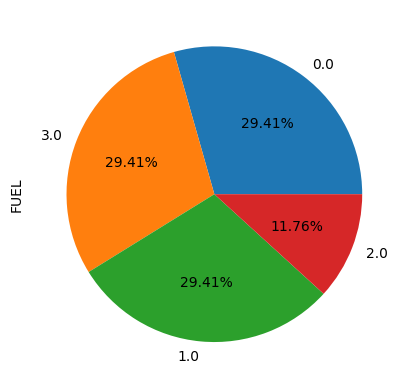

In [10]:
df['FUEL'].value_counts().plot(kind='pie', autopct='%.2f%%')
plt.show()

### **Let's look at the skewness of our data**

Col name: SIZE
Skewness: 0.2786998636581806


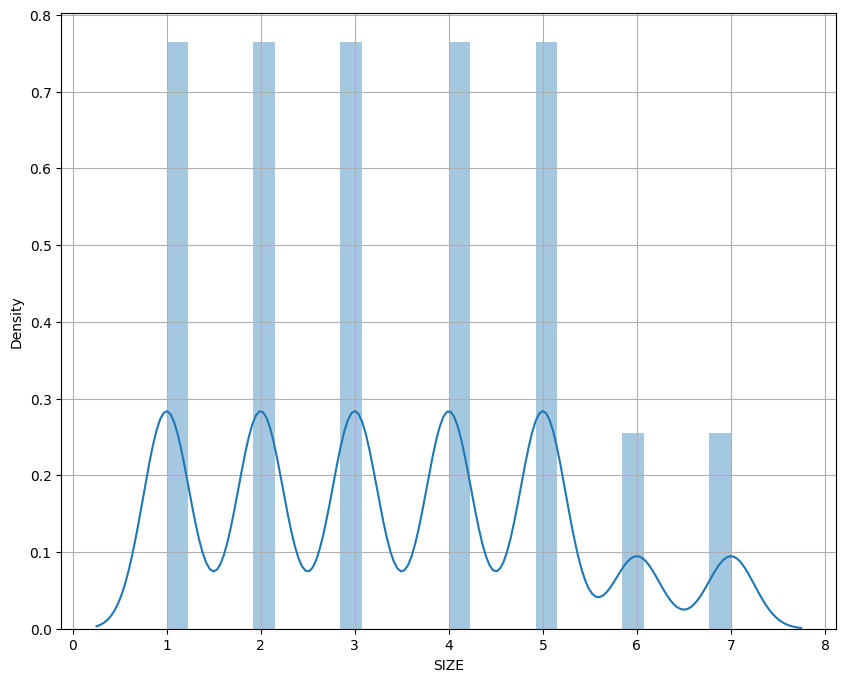

Col name: FUEL
Skewness: 0.20959140221588837


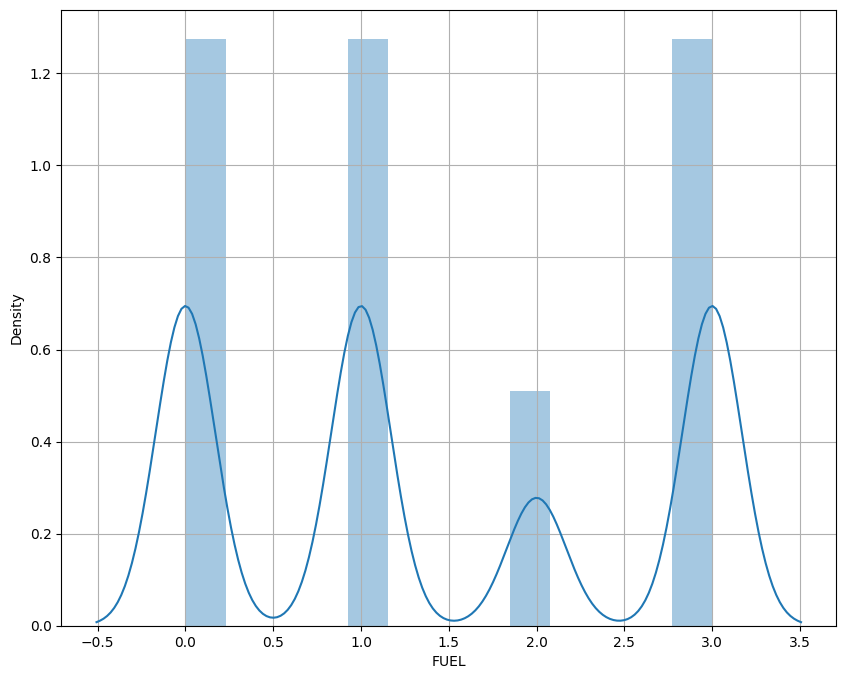

Col name: DISTANCE
Skewness: 0.0


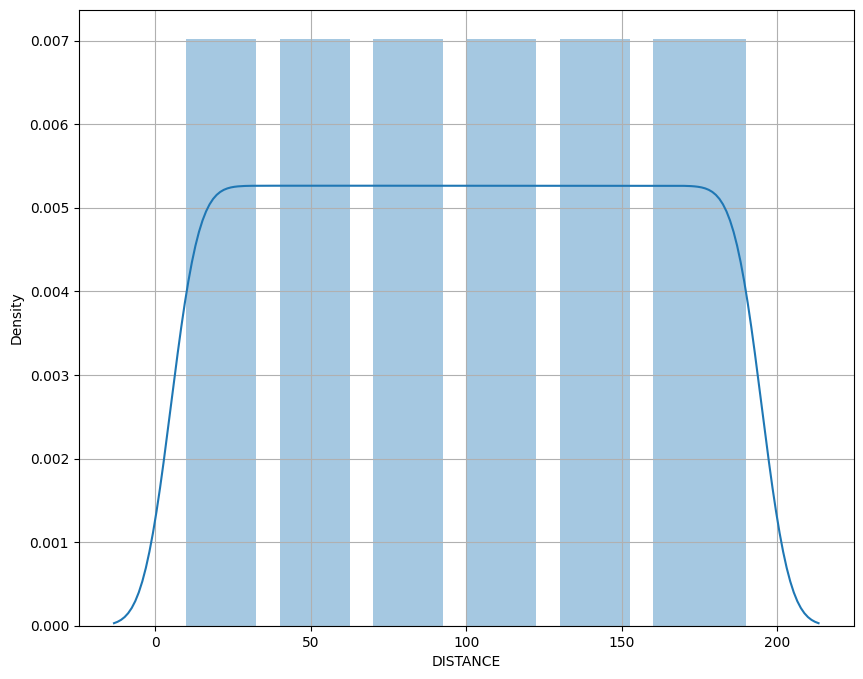

Col name: DESIBEL
Skewness: -0.17903195807888958


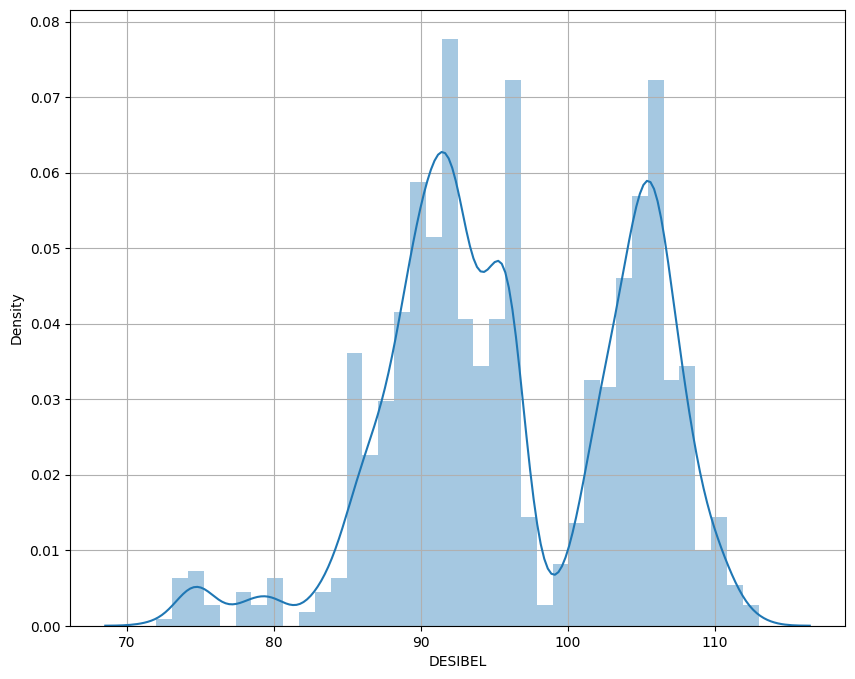

Col name: AIRFLOW
Skewness: 0.24434745944124117


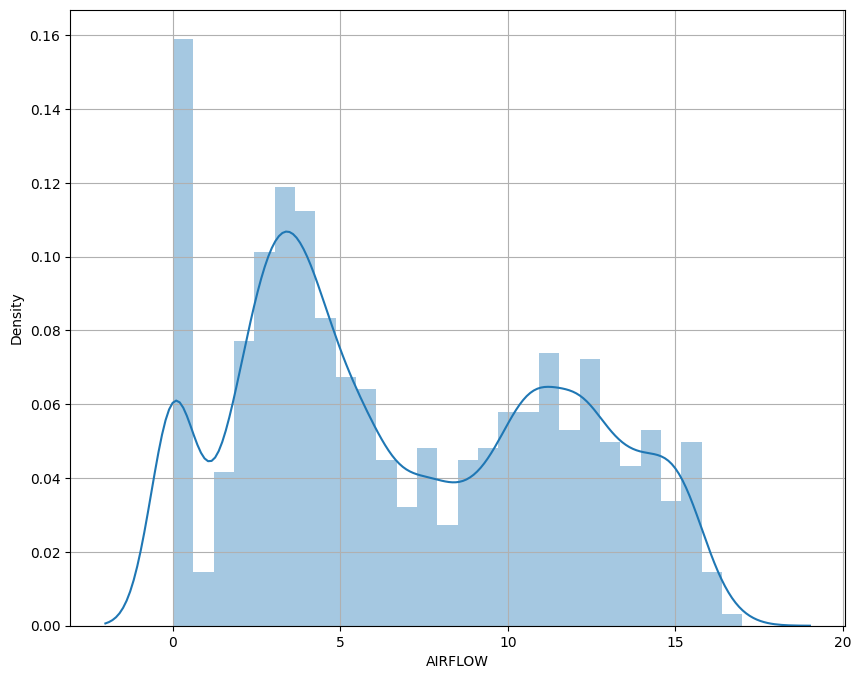

Col name: FREQUENCY
Skewness: 0.4348548916349596


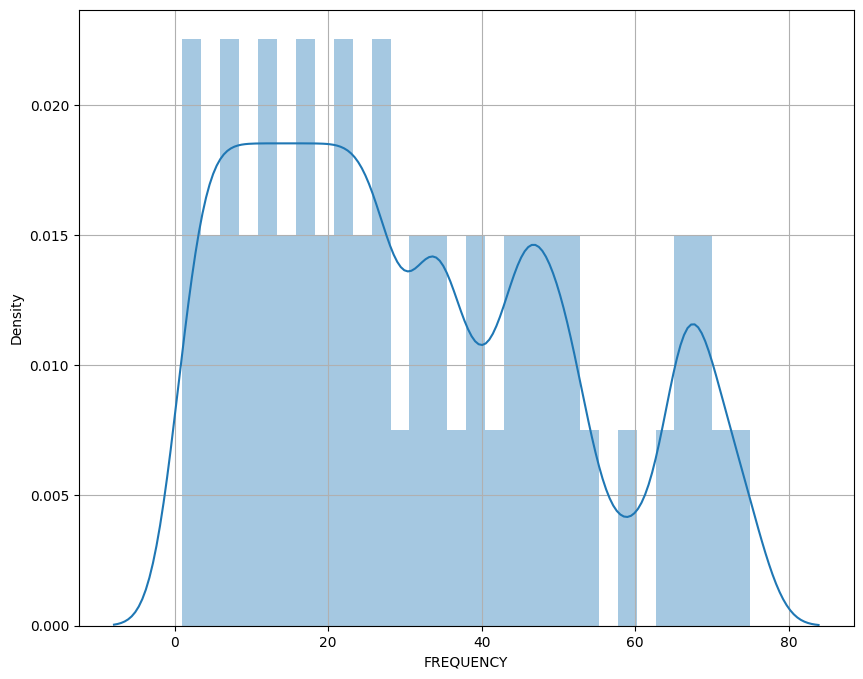

Col name: STATUS
Skewness: 0.008714679678955612


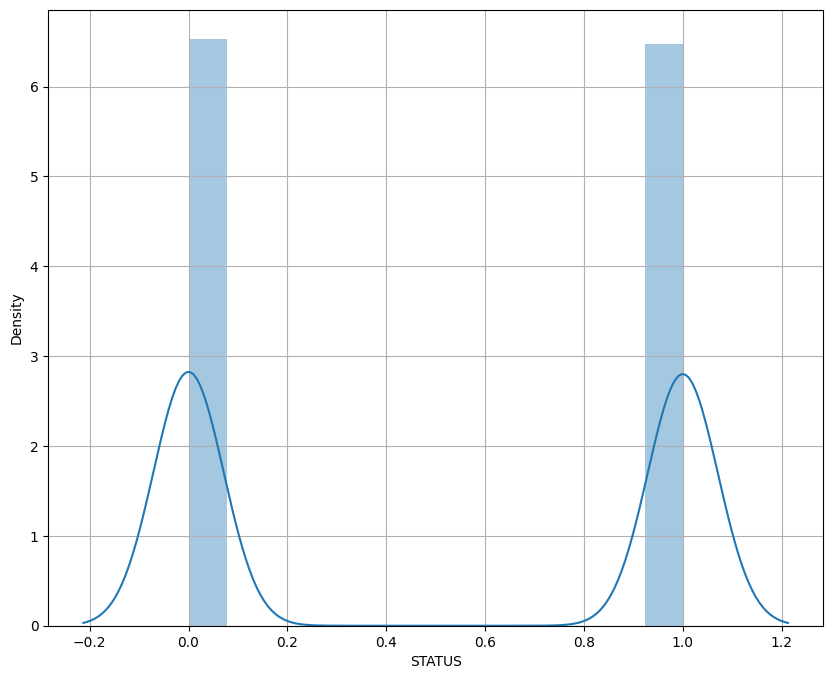

In [11]:
for col in df:
    print(f'Col name: {col}')
    print(f'Skewness: {skew(df[col])}')

    plt.figure(figsize=(10,8))
    sns.distplot(df[col])
    plt.grid(True)
    plt.show()

### **For a better understanding of the data correlation, we will build a heat map**

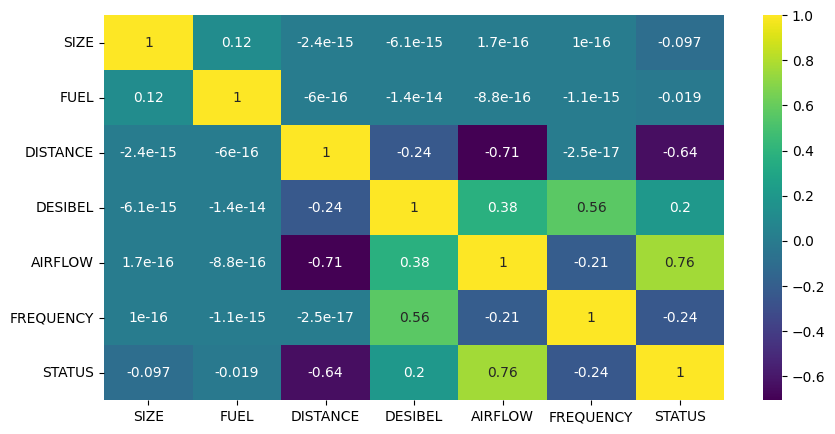

In [12]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.show()

### **Let's take a look at the uniqueness of values**

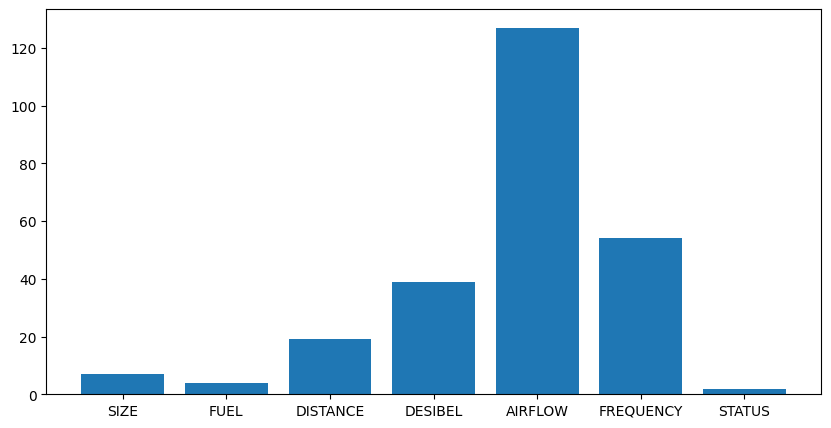

In [13]:
plt.figure(figsize=(10,5))
plt.bar(df.columns, df.nunique())
plt.show()

## **Preparing data for classification**
##Data Cleaning

1. Analyze the numerical and categorical features, and convert categorical feature into numerical.

In [38]:
df.columns

Index(['SIZE', 'FUEL', 'DISTANCE', 'DESIBEL', 'AIRFLOW', 'FREQUENCY',
       'STATUS'],
      dtype='object')

In [39]:
#Show categorical values
df['FUEL'].unique()

array(['gasoline', 'thinner', 'kerosene', 'lpg'], dtype=object)

In [41]:
# converting categorical column into numerical
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder()
df["FUEL"] = ord_encoder.fit_transform(df[["FUEL"]])
ord_encoder.categories_

[array(['gasoline', 'kerosene', 'lpg', 'thinner'], dtype=object)]

0 - Gasoline ; 1 - Kerosene ; 2 - LPG ; 3 - Thinner

In [43]:
x = df.iloc[:,:-1]
df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,0.0,10,96,0.0,75,0
1,1,0.0,10,96,0.0,72,1
2,1,0.0,10,96,2.6,70,1
3,1,0.0,10,96,3.2,68,1
4,1,0.0,10,109,4.5,67,1


In [44]:
y = df.iloc[:, -1]
y.head()

0    0
1    1
2    1
3    1
4    1
Name: STATUS, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [46]:
st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)
X_test = st_sc.fit_transform(X_test)

## **Training and results of the Logistic Regression model**

In [47]:
regressor = LogisticRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2614
           1       0.89      0.87      0.88      2619

    accuracy                           0.88      5233
   macro avg       0.88      0.88      0.88      5233
weighted avg       0.88      0.88      0.88      5233



In [51]:
# Save the model
dump(regressor, 'model.joblib')

# Load the model
regressor = load('model.joblib')

In [52]:
#Matrix Confusion
confusion_matrix(y_test,y_pred)

array([[2332,  282],
       [ 347, 2272]])

In [49]:
print(f'Model actual accuracy: {accuracy_score(y_test, y_pred)}')

Model actual accuracy: 0.8798012612268298
